# パッケージインストール

In [1]:
!pip install -q decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 81.7 MB/s eta 0:00:00


# サンプル画像ダウンロード

In [2]:
!mkdir examples

In [3]:
!wget https://huggingface.co/OpenGVLab/InternVL2-8B/resolve/main/examples/image1.jpg -O examples/image1.jpg -q
!wget https://huggingface.co/OpenGVLab/InternVL2-8B/resolve/main/examples/image2.jpg -O examples/image2.jpg -q
!wget https://huggingface.co/OpenGVLab/InternVL2-8B/resolve/main/examples/red-panda.mp4 -O examples/red-panda.mp4 -q

# モデル読み込み

In [4]:
model_name = 'OpenGVLab/InternVL2-1B'  # T4動作可能
# model_name = 'OpenGVLab/InternVL2-2B'  # T4動作可能
# model_name = 'OpenGVLab/InternVL2-4B'  # L4以上で動作可能（テキストチャットはT4動作可能、複数画像はL4でも動作不可）
# model_name = 'OpenGVLab/InternVL2-8B'  # L4以上で動作可能（複数画像はL4でも動作不可）
# model_name = 'OpenGVLab/InternVL2-26B'
# model_name = 'OpenGVLab/InternVL2-40B'
# model_name = 'OpenGVLab/InternVL2-Llama3-76B'

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

# モデル読み込み
model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True
).eval().cuda()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

# 前処理用関数

In [6]:
import numpy as np
from PIL import Image
import torchvision.transforms as T
from decord import VideoReader, cpu
from torchvision.transforms.functional import InterpolationMode

# 画像の平均値と標準偏差（ImageNetの統計値）
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# 画像変換を構築する関数
def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),  # 画像をRGBモードに変換
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),  # 画像のサイズを変更
        T.ToTensor(),  # 画像をテンソルに変換
        T.Normalize(mean=MEAN, std=STD)  # 画像を正規化
    ])
    return transform

# 最も近いアスペクト比を見つける関数
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

# 動的に画像を前処理する関数
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height  # 画像のアスペクト比を計算

    # 目標のアスペクト比のリストを生成
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # 目標のアスペクト比に最も近いものを見つける
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # 目標の幅と高さを計算
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # 画像のリサイズ
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # 画像を分割
        split_img = resized_img.crop(box)
        processed_images.append(split_img)

    assert len(processed_images) == blocks  # 分割した画像の数を確認
    if use_thumbnail and len(processed_images) != 1:
        # サムネイルを追加
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

# 画像を読み込み、前処理を行う関数
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')  # 画像をRGBモードで開く
    transform = build_transform(input_size=input_size)  # 画像変換を構築
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)  # 画像を前処理
    pixel_values = [transform(image) for image in images]  # 画像をテンソルに変換
    pixel_values = torch.stack(pixel_values)  # テンソルをスタック
    return pixel_values

# テキストベース チャット

In [7]:
generation_config = dict(max_new_tokens=1024, do_sample=False)

In [8]:
%%time

# 初回チャット
question = 'Hello, who are you?'
response, history = model.chat(tokenizer, None, question, generation_config, history=None, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Hello, who are you?
Assistant: I am an AI assistant whose name is InternVL, developed jointly by Shanghai AI Lab and SenseTime.

CPU times: user 1.32 s, sys: 145 ms, total: 1.46 s
Wall time: 2.19 s


In [9]:
%%time

# 会話履歴を使用してチャット
question = 'Can you tell me a story?'
response, history = model.chat(tokenizer, None, question, generation_config, history=history, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Can you tell me a story?
Assistant: Sure, here's a story:

Once upon a time, there was a young girl named Lily who lived in a small village. She was a curious and adventurous girl who loved exploring the world around her. One day, while wandering through the forest, she stumbled upon a hidden cave. Excited by the prospect of discovering something new, she decided to explore the cave.

As she entered the cave, she was amazed by the beauty of the surroundings. The cave was filled with colorful flowers, sparkling crystals, and strange creatures. Lily was fascinated by the world she had discovered and decided to stay in the cave for a while.

Over the next few days, Lily spent her days exploring the cave, learning about the different creatures and plants that lived there. She also discovered a hidden treasure that she had never seen before. It was a beautiful crystal that had been stolen from the cave by a group of thieves.

When Lily returned to the village, she was hailed as a her

# 画像認識（単一画像）

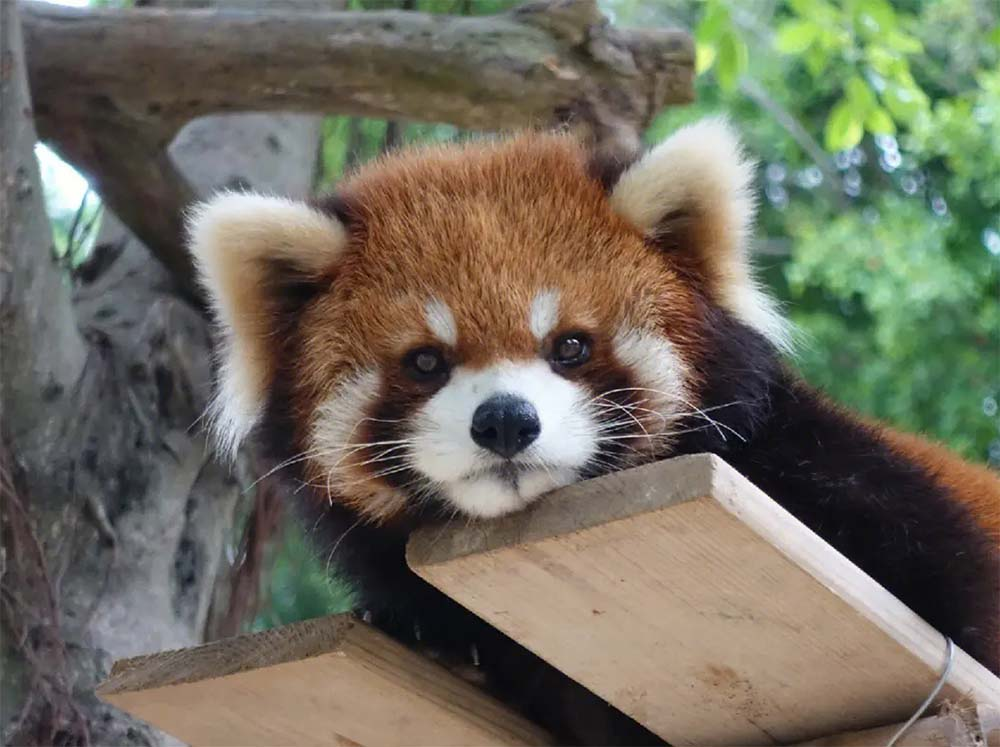

In [10]:
Image.open('./examples/image1.jpg')  # 画像確認

In [11]:
pixel_values = load_image('./examples/image1.jpg').to(torch.bfloat16).cuda()

In [12]:
%%time

# 1回のみの推論
question = '<image>\nPlease describe the image shortly.'
response = model.chat(tokenizer, pixel_values, question, generation_config)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: <image>
Please describe the image shortly.
Assistant: The image shows a red panda, a small, furry mammal known for its distinctive red and white fur. The red panda is resting on a wooden structure, possibly a platform or a bench, with its head leaning over the edge. The animal's large, expressive eyes and gentle expression are evident, and it appears to be looking directly at the camera. The background is blurred but suggests an outdoor setting with greenery, indicating that the photo might have been taken in a zoo or a wildlife park.

CPU times: user 8.71 s, sys: 107 ms, total: 8.82 s
Wall time: 8.9 s


In [13]:
%%time

# 複数回の推論（会話履歴指定）：初回
question = '<image>\nPlease describe the image in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: <image>
Please describe the image in detail.
Assistant: The image depicts a red panda, a small, intelligent mammal known for its distinctive red fur and white markings. The red panda is shown in a close-up shot, resting on a wooden structure, possibly a platform or a ledge. The animal's fur is predominantly red with white patches, particularly around its face, ears, and limbs. Its eyes are large and dark, and it has a black nose and mouth. The red panda's ears are perked up, and its eyes are focused intently on something off-camera. The background is blurred, but it appears to be an outdoor setting with greenery, suggesting that the photo was taken in a zoo or a wildlife park.

CPU times: user 9.86 s, sys: 126 ms, total: 9.98 s
Wall time: 9.95 s


In [14]:
%%time

# 複数回の推論（会話履歴指定）：2回目
question = 'Please write a poem according to the image.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Please write a poem according to the image.
Assistant: In the heart of a forest, where the trees sway,
A red panda rests, its fur a vivid red.
Its eyes, wide and bright, seem to peer,
At something unseen, a mystery to find.

Its ears, perked up, ready to hear,
A world beyond, a world of wonder.
A sight so rare, a creature so rare,
A panda, a wonder to behold.

Its fur, a tapestry of red and white,
A masterpiece of nature's art.
A creature so endearing, so rare,
A red panda, a wonder to behold.

Its eyes, a window to the world,
A glimpse into its world, a glimpse.
A creature so endearing, so rare,
A red panda, a wonder to behold.

CPU times: user 10.5 s, sys: 131 ms, total: 10.7 s
Wall time: 10.6 s


# 画像認識（複数画像結合）

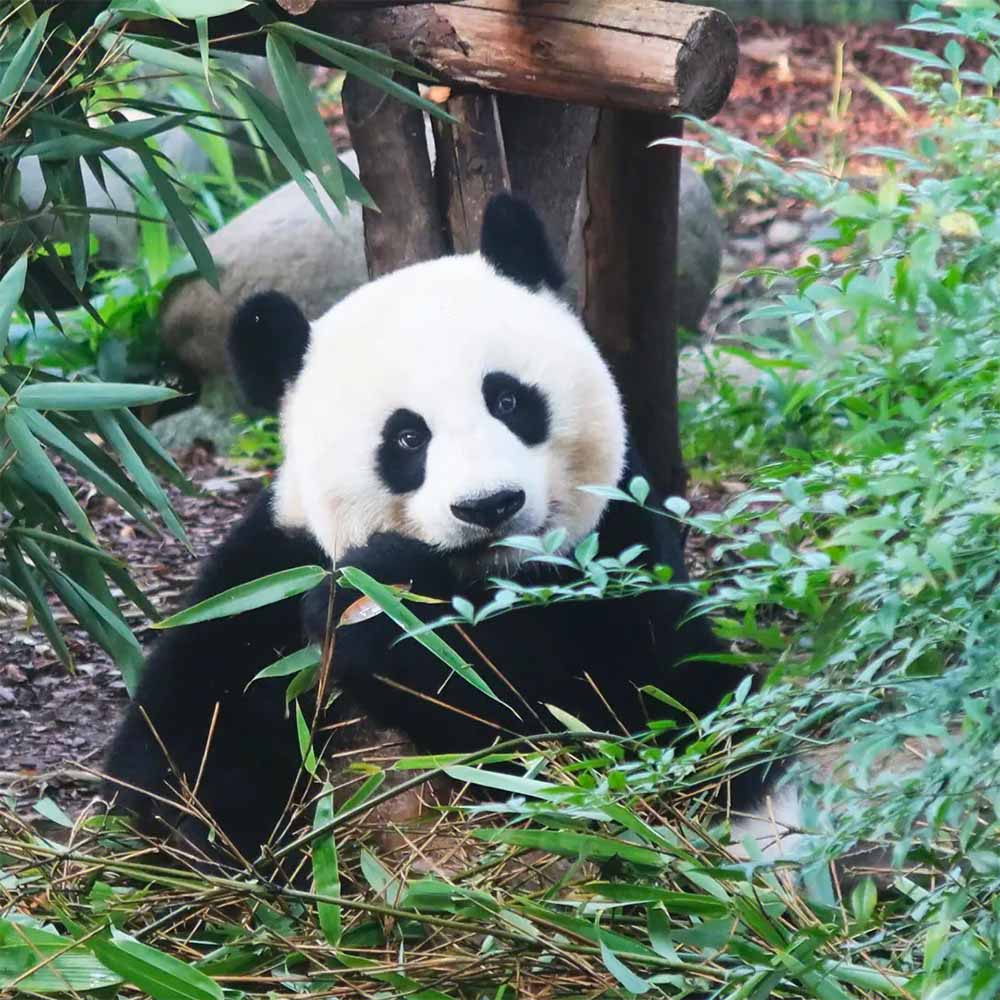

In [15]:
Image.open('./examples/image2.jpg')  # 画像確認

In [16]:
# 複数画像準備（画像の結合）
pixel_values1 = load_image('./examples/image1.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/image2.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)

In [17]:
%%time

question = '<image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=None, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: <image>
Describe the two images in detail.
Assistant: The image depicts a panda cub, which is a species of Asian bear, resting in a natural setting. The cub is positioned in a somewhat relaxed manner, with its head resting on its paws and its front paws holding onto a wooden structure. The cub's fur is predominantly black with white patches, and it has a large, expressive face with large, dark eyes and a small, black nose. The background shows a mix of green foliage and a wooden structure, possibly part of a zoo enclosure or a natural habitat.

The setting appears to be a zoo or a wildlife park, as indicated by the presence of the wooden structure and the natural elements like the greenery and the cub's habitat. The cub's calm demeanor and the natural environment suggest a sense of security and comfort in its surroundings.

CPU times: user 16.7 s, sys: 317 ms, total: 17 s
Wall time: 16.9 s


In [18]:
%%time

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, history=history, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: What are the similarities and differences between these two images.
Assistant: The two images depict two different aspects of the same subject: a panda cub and a panda resting in a natural setting. Here are the similarities and differences between the two images:

### Similarities:
1. **Subject**: Both images feature a panda cub.
2. **Location**: Both images are set in a natural environment, likely a zoo or a wildlife park.
3. **Fur Color**: Both images show the panda's black and white fur, with the cub having a predominantly black fur with white patches.
4. **Expression**: Both images capture the panda with a calm and relaxed demeanor.
5. **Setting**: Both images show the panda in a natural habitat, with green foliage and wooden structures.

### Differences:
1. **Cub's Position**: 
   - In the first image, the cub is resting on its paws, with its front paws holding onto a wooden structure.
   - In the second image, the cub is lying down, with its front paws resting on the groun

# 画像認識（複数画像リスト）

In [19]:
pixel_values1 = load_image('./examples/image1.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values2 = load_image('./examples/image2.jpg', max_num=12).to(torch.bfloat16).cuda()
pixel_values = torch.cat((pixel_values1, pixel_values2), dim=0)
num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]

In [20]:
%%time

question = 'Image-1: <image>\nImage-2: <image>\nDescribe the two images in detail.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list, history=None, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Image-1: <image>
Image-2: <image>
Describe the two images in detail.
Assistant: The two images provided are of pandas, specifically a red panda and a panda bear. Both animals are depicted in their natural habitat, which appears to be a forest or a wooded area.

### Image-1: 
- **Red Panda**: The red panda is a large, fluffy animal with a distinctive white face and body. It has a black nose and a black patch on its chest. The panda's fur is predominantly red, with white patches on its face and ears. The animal is resting on a wooden structure, possibly a tree branch, with its head turned slightly towards the camera. The background is blurred, but it appears to be a natural setting with green foliage and trees.

### Image-2: 
- **Panda Bear**: The panda bear is a smaller, black and white animal with a distinctive black nose and a black patch on its chest. It has a white face and body. The bear is lying on the ground amidst green foliage, with its head turned towards the camera. Th

In [21]:
%%time

question = 'What are the similarities and differences between these two images.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config,
                               num_patches_list=num_patches_list, history=history, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: What are the similarities and differences between these two images.
Assistant: The two images of pandas provide a fascinating glimpse into their physical characteristics and behaviors. Let's delve into the similarities and differences between the two images:

### Similarities:
1. **Species**: Both images depict pandas.
2. **Physical Characteristics**: Both pandas share the same physical characteristics, including the distinctive red and white fur, black patches on their faces and ears, and black noses.
3. **Behavior**: Both images show pandas in their natural habitat, resting or lying on the ground amidst green foliage.

### Differences:
1. **Size and Habitat**: 
   - **Size**: The red panda is larger, with a body length ranging from 1.5 to 2 meters (4.9 to 7.2 feet). The panda bear is smaller, with a body length ranging from 1.2 to 1.5 meters (3.7 to 4.9 feet).
   - **Habitat**: The red panda is native to the Himalayas and is found in mountainous regions, while the panda bear i

# 動画認識

In [22]:
def get_index(bound, fps, max_frame, first_idx=0, num_segments=32):
    if bound:
        start, end = bound[0], bound[1]
    else:
        start, end = -100000, 100000
    start_idx = max(first_idx, round(start * fps))
    end_idx = min(round(end * fps), max_frame)
    seg_size = float(end_idx - start_idx) / num_segments
    frame_indices = np.array([
        int(start_idx + (seg_size / 2) + np.round(seg_size * idx))
        for idx in range(num_segments)
    ])
    return frame_indices

# 動画の読み込みと前処理
def load_video(video_path, bound=None, input_size=448, max_num=1, num_segments=32):
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    max_frame = len(vr) - 1
    fps = float(vr.get_avg_fps())

    pixel_values_list, num_patches_list = [], []
    transform = build_transform(input_size=input_size)
    frame_indices = get_index(bound, fps, max_frame, first_idx=0, num_segments=num_segments)
    for frame_index in frame_indices:
        img = Image.fromarray(vr[frame_index].asnumpy()).convert('RGB')
        img = dynamic_preprocess(img, image_size=input_size, use_thumbnail=True, max_num=max_num)
        pixel_values = [transform(tile) for tile in img]
        pixel_values = torch.stack(pixel_values)
        num_patches_list.append(pixel_values.shape[0])
        pixel_values_list.append(pixel_values)
    pixel_values = torch.cat(pixel_values_list)
    return pixel_values, num_patches_list

# 動画のパスを指定して読み込み
video_path = './examples/red-panda.mp4'
pixel_values, num_patches_list = load_video(video_path, num_segments=8, max_num=1)
pixel_values = pixel_values.to(torch.bfloat16).cuda()

In [23]:
%%time

video_prefix = ''.join([f'Frame{i+1}: <image>\n' for i in range(len(num_patches_list))])
question = video_prefix + 'What is the red panda doing?'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, num_patches_list=num_patches_list, history=None, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Frame1: <image>
Frame2: <image>
Frame3: <image>
Frame4: <image>
Frame5: <image>
Frame6: <image>
Frame7: <image>
Frame8: <image>
What is the red panda doing?
Assistant: The red panda is seen hanging upside down from a tree branch.

CPU times: user 4.42 s, sys: 62.5 ms, total: 4.48 s
Wall time: 4.44 s


In [24]:
%%time

question = 'Describe this video in detail. Don\'t repeat.'
response, history = model.chat(tokenizer, pixel_values, question, generation_config, num_patches_list=num_patches_list, history=history, return_history=True)

print(f'\nUser: {question}\nAssistant: {response}\n')

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



User: Describe this video in detail. Don't repeat.
Assistant: The video shows two red pandas hanging upside down from a tree branch. One panda is black and the other is red. They appear to be enjoying the view and seem to be in a peaceful and relaxed state. The red panda is hanging upside down from a tree branch, while the black panda is hanging from a different branch. The background is blurred, but it seems to be a natural setting with greenery and trees. The red panda is hanging upside down, and the black panda is hanging from a different branch. The video captures the serene and peaceful atmosphere of the red panda's natural habitat.

CPU times: user 7.57 s, sys: 71.3 ms, total: 7.64 s
Wall time: 7.61 s
